In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import pickle

import seaborn as sns

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler    
import xgboost

from sklearn.metrics import mean_squared_error
from math import sqrt



In [2]:
# Load the dataset
data = pd.read_csv("Bengaluru_House_Data.csv")
data.head()

#displays the first 5 rows of the dataset (by default)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
data.shape

#a tuple that gives number of dimensions in an array

(13320, 9)

In [4]:
data.describe

#gives description of all the data

<bound method NDFrame.describe of                  area_type   availability                  location  \
0      Super built-up Area         19-Dec  Electronic City Phase II   
1                Plot Area  Ready To Move          Chikka Tirupathi   
2            Built-up Area  Ready To Move               Uttarahalli   
3      Super built-up Area  Ready To Move        Lingadheeranahalli   
4      Super built-up Area  Ready To Move                  Kothanur   
...                    ...            ...                       ...   
13315        Built-up Area  Ready To Move                Whitefield   
13316  Super built-up Area  Ready To Move             Richards Town   
13317        Built-up Area  Ready To Move     Raja Rajeshwari Nagar   
13318  Super built-up Area         18-Jun           Padmanabhanagar   
13319  Super built-up Area  Ready To Move              Doddathoguru   

            size  society total_sqft  bath  balcony   price  
0          2 BHK  Coomee        1056   2.0      1.0

In [5]:
data.isnull().sum()

#returns the number of missing values in the data set

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [6]:
#Data clean: handle null values
data = data.dropna()

In [7]:
data.area_type.unique()

#displays all the unique values 

array(['Super built-up Area', 'Plot Area', 'Built-up Area', 'Carpet Area'],
      dtype=object)

In [8]:
#drop availability because it's not required 
data = data.drop('availability',axis=1)

In [9]:
data.location.unique()

#again return unique values after removing the availability column


array(['Electronic City Phase II', 'Chikka Tirupathi',
       'Lingadheeranahalli', 'Whitefield', '7th Phase JP Nagar',
       'Sarjapur', 'Mysore Road', 'Bisuvanahalli',
       'Raja Rajeshwari Nagar', 'Ramakrishnappa Layout', 'Binny Pete',
       'Thanisandra', ' Thanisandra', 'Electronic City',
       'Ramagondanahalli', 'Yelahanka', 'Hebbal', 'Kanakpura Road',
       'Kundalahalli', 'Sarjapur  Road', 'Ganga Nagar', 'Doddathoguru',
       'Adarsh Nagar', 'Bhoganhalli', 'Lakshminarayana Pura',
       'Begur Road', 'Varthur', 'Gunjur', 'Hegde Nagar', 'Haralur Road',
       'Hennur Road', 'Cholanayakanahalli', 'Kodanda Reddy Layout',
       'EPIP Zone', 'Dasanapura', 'Kasavanhalli', 'Sanjay nagar',
       'Kengeri', 'Yeshwanthpur', 'Chandapura', 'Kothanur',
       'Green View Layout', 'Shantiniketan Layout', 'Rajaji Nagar',
       'Devanahalli', 'Byatarayanapura', 'Akshaya Nagar',
       'LB Shastri Nagar', 'Hormavu', 'Peenya', 'Kudlu Gate',
       '8th Phase JP Nagar', 'Chandra Layout

In [10]:
len(data.location.unique())

#return the number of unique locations in the dataset

634

In [11]:
location_count = data.groupby('location').size().sort_values(ascending=False)
location_count

#groups the locations with their frequencies

location
Whitefield                        397
Sarjapur  Road                    310
Electronic City                   236
Kanakpura Road                    216
Thanisandra                       212
                                 ... 
Kalhalli                            1
 Bhoganhalli                        1
KSRTC Layout                        1
KR Garden                           1
Yeshwanthpur Industrial Suburb      1
Length: 634, dtype: int64

In [12]:
len(location_count[location_count<=10])

#returns no. of locations with count <=10

491

In [13]:
location_less_10 = location_count[location_count<=10]

#all the locations that have frequency <=10 have been named location_less_10

In [14]:
#if the location have less than 10 or 10 houses than that location are known as other location
data.location = data.location.apply(lambda x: 'other' if x in location_less_10 else x)

In [15]:
len(data.location.unique())

#returns the number of unique locations

144

In [16]:
data['bhk'] = data['size'].apply(lambda x: int(x.split(' ')[0]))
data.bhk.unique() 


array([ 2,  4,  3,  1,  5, 11,  9,  6,  7], dtype=int64)

In [17]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None
# in case there is a range of values, then it returns the average of the min and max value in the range

In [18]:
data.total_sqft = data.total_sqft.apply(convert_sqft_to_num)
data = data[data.total_sqft.notnull()]
data.head()

#saves the modified sqft by calculating averages and then displays the first 5 rows of the dataset

,area_type,location,size,society,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,Electronic City Phase II,2 BHK,Coomee,1056.0,2.0,1.0,39.07,2
1,Plot Area,Chikka Tirupathi,4 Bedroom,Theanmp,2600.0,5.0,3.0,120.00,4
3,Super built-up Area,Lingadheeranahalli,3 BHK,Soiewre,1521.0,3.0,1.0,95.00,3
5,Super built-up Area,Whitefield,2 BHK,DuenaTa,1170.0,2.0,1.0,38.00,2
11,Plot Area,Whitefield,4 Bedroom,Prrry M,2785.0,5.0,3.0,295.00,4


In [19]:
#drop society column because it's not required
data = data.drop('society',axis=1)

In [20]:
data.head()

#once again displays the first 5 rows

,area_type,location,size,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3
5,Super built-up Area,Whitefield,2 BHK,1170.0,2.0,1.0,38.00,2
11,Plot Area,Whitefield,4 Bedroom,2785.0,5.0,3.0,295.00,4


In [21]:
#create new column price_sqft that contain price per sqft
data['price_sqft'] = data.price*100000/data.total_sqft

In [22]:
#remove outlier using standard deviation
upper_limit = data.price_sqft.mean() + data.price_sqft.std()
lower_limit = data.price_sqft.mean() - data.price_sqft.std()
data = data[data.price_sqft<upper_limit] 
data = data[data.price_sqft > lower_limit]

In [23]:
#remove 2BHK house that price per sqft is less than the mean of 1bhk house price
def remove_bhk_outliers(data):
    exclude_indices = np.array([])
    for location, location_df in data.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_sqft),
                'std': np.std(bhk_df.price_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_sqft<(stats['mean'])].index.values)
    return data.drop(exclude_indices,axis='index')
data = remove_bhk_outliers(data)

In [24]:
data = data.drop('price_sqft',axis=1)

In [25]:
#apply one hot encoding in location column
dummies = pd.get_dummies(data.location)
location_cat = pd.get_dummies(data.location)
dummies.head()

,1st Phase JP Nagar,5th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,...,Tumkur Road,Uttarahalli,Varthur,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur,other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
data = pd.concat([data,dummies.drop('1st Phase JP Nagar',axis='columns')],axis='columns')
data.head()

,area_type,location,size,total_sqft,bath,balcony,price,bhk,5th Phase JP Nagar,7th Phase JP Nagar,...,Tumkur Road,Uttarahalli,Varthur,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur,other
0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,0,0,...,0,0,0,0,0,0,0,0,0,0
11,Plot Area,Whitefield,4 Bedroom,2785.0,5.0,3.0,295.00,4,0,0,...,0,0,0,0,0,1,0,0,0,0
12,Super built-up Area,7th Phase JP Nagar,2 BHK,1000.0,2.0,1.0,38.00,2,0,1,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#apply one hot encoding in area column
dummies = pd.get_dummies(data.area_type)
dummies.head()

,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,0,0,0,1
1,0,0,1,0
3,0,0,0,1
11,0,0,1,0
12,0,0,0,1


In [28]:
data = pd.concat([data,dummies],axis='columns')
data.head()

,area_type,location,size,total_sqft,bath,balcony,price,bhk,5th Phase JP Nagar,7th Phase JP Nagar,...,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur,other,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,Super built-up Area,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,0,0,...,0,0,0,0,0,0,0,0,0,1
11,Plot Area,Whitefield,4 Bedroom,2785.0,5.0,3.0,295.00,4,0,0,...,0,1,0,0,0,0,0,0,1,0
12,Super built-up Area,7th Phase JP Nagar,2 BHK,1000.0,2.0,1.0,38.00,2,0,1,...,0,0,0,0,0,0,0,0,0,1


In [29]:
data = data.drop(['location','size','area_type'] , axis=1)

In [30]:
data.head()

,total_sqft,bath,balcony,price,bhk,5th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur,other,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,1056.0,2.0,1.0,39.07,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2600.0,5.0,3.0,120.00,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1521.0,3.0,1.0,95.00,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11,2785.0,5.0,3.0,295.00,4,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
12,1000.0,2.0,1.0,38.00,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
#split data into dependent feature & independent feature
X = data.drop('price',axis=1)

In [32]:
Y = data['price']

In [33]:
# Splitting the dataset into training and test set.  

x_train, x_test, y_train, y_test= tts(X, Y, test_size= 0.25, random_state=28)

In [34]:
#feature Scaling  

st_x= StandardScaler()    
x_train= st_x.fit_transform(x_train)    
x_test= st_x.transform(x_test)   

In [35]:
classifier=xgboost.XGBRegressor()
classifier.fit(x_train,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [36]:
# Hyper Parameter Optimization
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

# Set up the random search with 5-fold cross validation
random_cv = RandomizedSearchCV(estimator=classifier,
param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
return_train_score = True,
random_state=28)


In [37]:
random_cv.fit(x_train,y_train)
random_cv.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=900, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [38]:
regressor_gbdt = xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
max_depth=2, min_child_weight=1, missing=1, n_estimators=900,
n_jobs=1, nthread=None, objective='reg:squarederror', random_state=28,
reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, subsample=1)
regressor_gbdt.fit(x_train,y_train)

# Saving as pickle file
filename = 'finalized_model.pkl'
pickle.dump(regressor_gbdt, open(filename,'wb'))



In [39]:
y_pred_gbdt = regressor_gbdt.predict(x_test)

In [40]:
y_pred_gbdt

array([52.417362, 59.488613, 12.506068, ..., 42.579426, 34.814323,
       55.89734 ], dtype=float32)

In [41]:
mse = mean_squared_error(y_test, y_pred_gbdt)
sqrt(mse)


27.48816704053482

Text(0.5, 1.0, 'Prices vs Predicted prices: ₹y_i₹ vs ₹\\hat{y}_i₹')

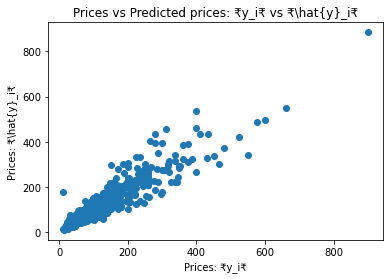

In [42]:
plt.scatter(y_test, y_pred_gbdt)
plt.xlabel("Prices: ₹y_i₹")
plt.ylabel("Prices: ₹\hat{y}_i₹")
plt.title("Prices vs Predicted prices: ₹y_i₹ vs ₹\hat{y}_i₹")


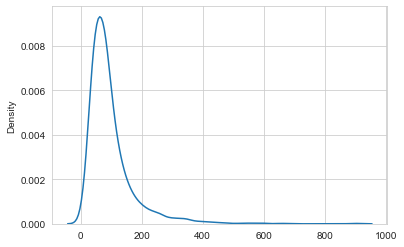

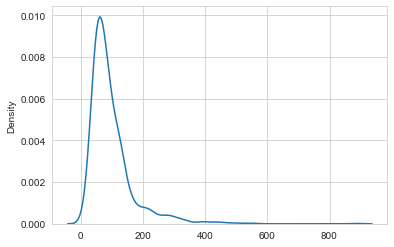

In [43]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(y_test))
plt.show()

sns.kdeplot(np.array(y_pred_gbdt))
plt.show()


In [44]:
regressor_rf = RandomForestRegressor(random_state = 28)
regressor_rf.fit(x_train, y_train)


RandomForestRegressor(random_state=28)

In [45]:
y_pred_rf = regressor_rf.predict(x_test)

In [46]:
y_pred_rf

array([51.72312302, 65.0271    , 30.12807583, ..., 51.07693333,
       32.41045   , 46.85367   ])

In [47]:
mse = mean_squared_error(y_test, y_pred_rf)
sqrt(mse)


28.74199002384812

Text(0.5, 1.0, 'Prices vs Predicted prices: ₹y_i₹ vs ₹\\hat{y}_i₹')

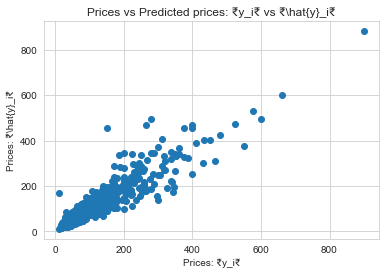

In [48]:
plt.scatter(y_test, y_pred_rf)
plt.xlabel("Prices: ₹y_i₹")
plt.ylabel("Prices: ₹\hat{y}_i₹")
plt.title("Prices vs Predicted prices: ₹y_i₹ vs ₹\hat{y}_i₹")


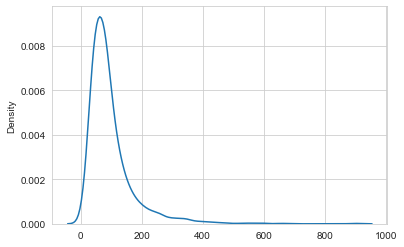

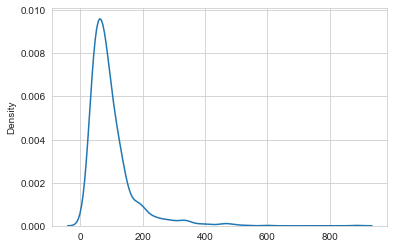

In [49]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(y_test))
plt.show()
sns.kdeplot(np.array(y_pred_rf))
plt.show()


In [50]:
x_train1, x_test1, y_train1, y_test1 = tts(X, Y, test_size = 0.2, random_state = 28)
print(x_train1.shape)
print(x_test1.shape)
print(y_train1.shape)
print(y_test1.shape)

(4191, 151)
(1048, 151)
(4191,)
(1048,)


In [51]:
classifier=xgboost.XGBRegressor()
classifier.fit(x_train1,y_train1)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [52]:
# Hyper Parameter Optimization
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

# Set up the random search with 5-fold cross validation
random_cv = RandomizedSearchCV(estimator=classifier,
param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
return_train_score = True,
random_state=28)


In [53]:
random_cv.fit(x_train1,y_train1)
random_cv.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=900, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [54]:
regressor_gbdt = xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
max_depth=2, min_child_weight=1, missing=1, n_estimators=900,
n_jobs=1, nthread=None, objective='reg:squarederror', random_state=28,
reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, subsample=1)
regressor_gbdt.fit(x_train1,y_train1)

# Saving as pickle file
filename = 'finalized_model.pkl'
pickle.dump(regressor_gbdt, open(filename,'wb'))


In [55]:
y_pred_gbdt1 = regressor_gbdt.predict(x_test1)

In [56]:
y_pred_gbdt1

array([ 50.883877,  59.36891 ,  12.528022, ...,  69.074875,  51.196785,
       210.11153 ], dtype=float32)

In [57]:
mse = mean_squared_error(y_test1, y_pred_gbdt1)
sqrt(mse)


27.605272525325667

Text(0.5, 1.0, 'Prices vs Predicted prices: ₹y_i₹ vs ₹\\hat{y}_i₹')

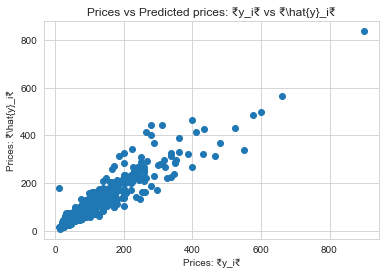

In [58]:
plt.scatter(y_test1, y_pred_gbdt1)
plt.xlabel("Prices: ₹y_i₹")
plt.ylabel("Prices: ₹\hat{y}_i₹")
plt.title("Prices vs Predicted prices: ₹y_i₹ vs ₹\hat{y}_i₹")


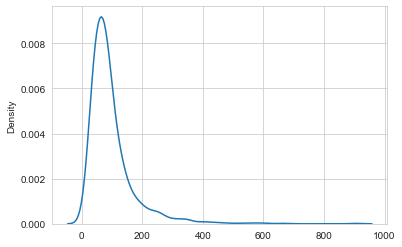

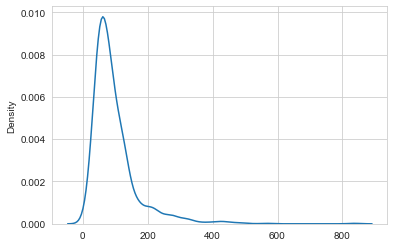

In [59]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(y_test1))
plt.show()
sns.kdeplot(np.array(y_pred_gbdt1))
plt.show()


In [60]:
regressor_rf = RandomForestRegressor(random_state = 28)
regressor_rf.fit(x_train1, y_train1)

RandomForestRegressor(random_state=28)

In [61]:
y_pred_rf1 = regressor_rf.predict(x_test1)

In [62]:
y_pred_rf1

array([ 51.09836833,  64.94372857,  27.88542857, ...,  75.25148384,
        62.04583333, 184.12666667])

In [63]:
mse = mean_squared_error(y_test1, y_pred_rf1)
sqrt(mse)

27.72837449871274

Text(0.5, 1.0, 'Prices vs Predicted prices: ₹y_i₹ vs ₹\\hat{y}_i₹')

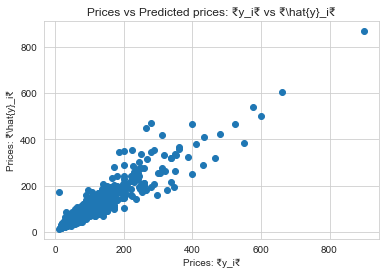

In [64]:
plt.scatter(y_test1, y_pred_rf1)
plt.xlabel("Prices: ₹y_i₹")
plt.ylabel("Prices: ₹\hat{y}_i₹")
plt.title("Prices vs Predicted prices: ₹y_i₹ vs ₹\hat{y}_i₹")


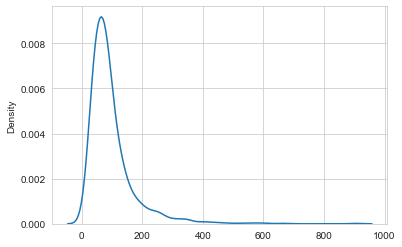

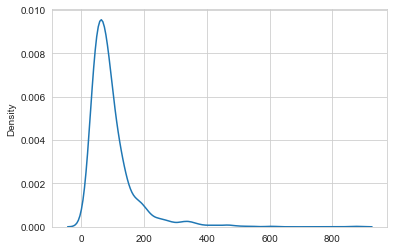

In [65]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(y_test1))
plt.show()

sns.kdeplot(np.array(y_pred_rf1))
plt.show()

In [66]:
x_train2, x_test2, y_train2, y_test2 = tts(X, Y, test_size = 0.35, random_state = 28)
print(x_train2.shape)
print(x_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(3405, 151)
(1834, 151)
(3405,)
(1834,)


In [67]:
classifier=xgboost.XGBRegressor()
classifier.fit(x_train2,y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [68]:
# Hyper Parameter Optimization
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

# Set up the random search with 5-fold cross validation
random_cv = RandomizedSearchCV(estimator=classifier,
param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
return_train_score = True,
random_state=28)


In [69]:
random_cv.fit(x_train2,y_train2)
random_cv.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=2,
             missing=nan, monotone_constraints='()', n_estimators=900, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [70]:
regressor_gbdt = xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
max_depth=2, min_child_weight=1, missing=1, n_estimators=900,
n_jobs=1, nthread=None, objective='reg:squarederror', random_state=28,
reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, subsample=1)
regressor_gbdt.fit(x_train2,y_train2)

# Saving as pickle file
filename = 'finalized_model.pkl'
pickle.dump(regressor_gbdt, open(filename,'wb'))


In [71]:
y_pred_gbdt2 = regressor_gbdt.predict(x_test2)

In [72]:
y_pred_gbdt2

array([ 50.879837,  61.63524 ,   9.519239, ..., 312.643   , 145.66873 ,
        93.69833 ], dtype=float32)

In [73]:
mse = mean_squared_error(y_test2, y_pred_gbdt2)
sqrt(mse)


27.737558011391368

Text(0.5, 1.0, 'Prices vs Predicted prices: ₹y_i₹ vs ₹\\hat{y}_i₹')

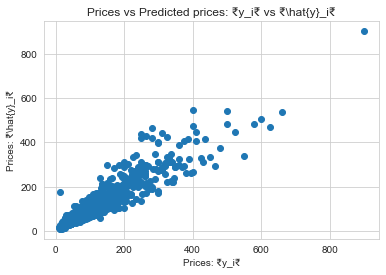

In [74]:
plt.scatter(y_test2, y_pred_gbdt2)
plt.xlabel("Prices: ₹y_i₹")
plt.ylabel("Prices: ₹\hat{y}_i₹")
plt.title("Prices vs Predicted prices: ₹y_i₹ vs ₹\hat{y}_i₹")


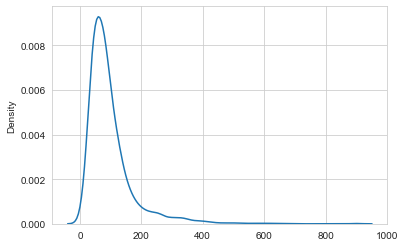

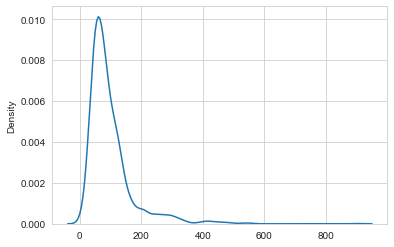

In [75]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(y_test2))
plt.show()
sns.kdeplot(np.array(y_pred_gbdt2))
plt.show()


In [76]:
regressor_rf = RandomForestRegressor(random_state = 28)
regressor_rf.fit(x_train2, y_train2)


RandomForestRegressor(random_state=28)

In [77]:
y_pred_rf2 = regressor_rf.predict(x_test2)

In [78]:
y_pred_rf2

array([ 58.40819048,  62.5379    ,  28.65805   , ..., 324.59859524,
       143.53066667, 105.30777143])

In [79]:
mse = mean_squared_error(y_test2, y_pred_rf2)
sqrt(mse)

28.46580738946621

Text(0.5, 1.0, 'Prices vs Predicted prices: ₹y_i₹ vs ₹\\hat{y}_i₹')

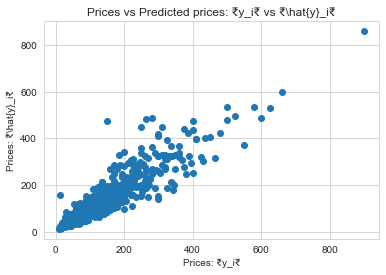

In [80]:
plt.scatter(y_test2, y_pred_rf2)
plt.xlabel("Prices: ₹y_i₹")
plt.ylabel("Prices: ₹\hat{y}_i₹")
plt.title("Prices vs Predicted prices: ₹y_i₹ vs ₹\hat{y}_i₹")


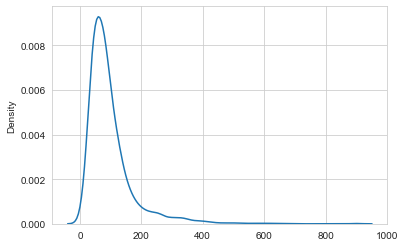

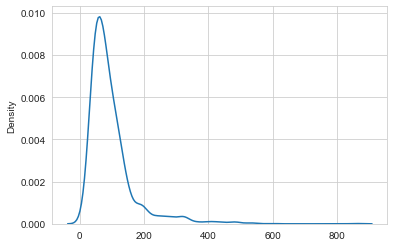

In [81]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(y_test2))
plt.show()

sns.kdeplot(np.array(y_pred_rf2))
plt.show()


In [85]:
cat = data.drop(['price'] , axis=1)
index_dict = dict(zip(cat.columns,range(cat.shape[1])))
with open('cat', 'wb') as fid:
    pickle.dump(index_dict, fid,2)  

In [86]:
#save the column name
location_list = list(zip(location_cat.columns,range(cat.shape[1])))

In [100]:
with open('location_cat', 'wb') as fid:
    pickle.dump(location_list, fid,2)  

In [90]:
#def predict(location,area,size,bath,balcony,total_sqft):
#    output = np.zeros(151)
 #   output[0] = total_sqft
  #  output[1] = bath
   # output[2] = balcony
   # output[3] = size
    
    #result_location = location
    #if result_location not in location_cat:
     #   output[146] = 1
    #else:
     #   output[index_dict[str(location)]] = 1
    
    #return regressor_rf.predict([output])[0]